<a href="https://colab.research.google.com/github/CheapSoch/Test/blob/main/Fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Apr 22 15:53 kaggle.json
100% 3.58G/3.58G [00:35<00:00, 144MB/s]
100% 3.58G/3.58G [00:35<00:00, 109MB/s]


In [4]:
import zipfile
import os

curDir = os.getcwd()
print(curDir)

local_zip = '/content/fruits-fresh-and-rotten-for-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')

zip_ref.close()

/content


(488, 370)


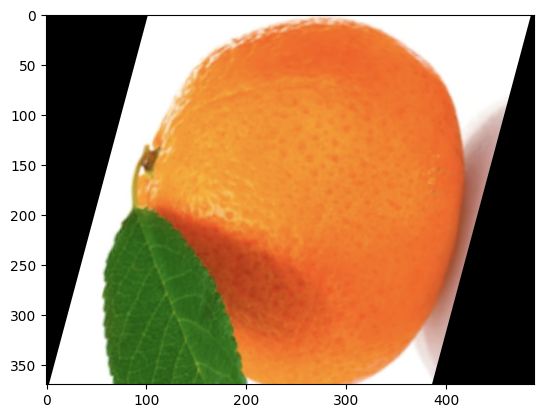

In [5]:
import random
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import os

filenames = os.listdir('/content/dataset/train/freshoranges')
sample = random.choice(filenames)
image = load_img('/content/dataset/train/freshoranges/'+sample)
plt.imshow(image)
print(image.size)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=15,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
                    'dataset/train',
                    target_size = (150,150),
                    batch_size = 15,
                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
                    'dataset/test',
                    target_size=(150,150),
                    batch_size= 15,
                    class_mode='categorical'
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [8]:
## Define a Callback function
desired_accuracy = 0.999


class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>desired_accuracy):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

my_callback = myCallback()

In [9]:
baseModel = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(150, 150, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs = headModel)

# Freeze the baseModel layers
for layer in baseModel.layers :
    layer.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [11]:
## Hyperparameter
INIT_LR = 1e-3
BS = 15
EPOCHS = 25

In [12]:
print("[INFO] compiling model...")
import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy",	metrics=["accuracy"])

[INFO] compiling model...


In [14]:
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            steps_per_epoch=len(train_generator) // BS,
            validation_steps=len(validation_generator) // BS,
            epochs=30,
            verbose=1,
            callbacks=[my_callback]
)

Epoch 1/30
48/48 [==============================] - 85s 2s/step - loss: 0.0500 - accuracy: 0.9611 - val_loss: 0.0263 - val_accuracy: 0.9778
Epoch 2/30
48/48 [==============================] - 80s 2s/step - loss: 0.0610 - accuracy: 0.9431 - val_loss: 0.0322 - val_accuracy: 0.9500
Epoch 3/30
48/48 [==============================] - 81s 2s/step - loss: 0.0391 - accuracy: 0.9667 - val_loss: 0.0292 - val_accuracy: 0.9611
Epoch 4/30
48/48 [==============================] - 80s 2s/step - loss: 0.0550 - accuracy: 0.9525 - val_loss: 0.0440 - val_accuracy: 0.9667
Epoch 5/30
48/48 [==============================] - 80s 2s/step - loss: 0.0588 - accuracy: 0.9486 - val_loss: 0.0417 - val_accuracy: 0.9667
Epoch 6/30
48/48 [==============================] - 80s 2s/step - loss: 0.0606 - accuracy: 0.9569 - val_loss: 0.0315 - val_accuracy: 0.9722
Epoch 7/30
48/48 [==============================] - 75s 2s/step - loss: 0.0525 - accuracy: 0.9542 - val_loss: 0.0267 - val_accuracy: 0.9778
Epoch 8/30
48/48 [==

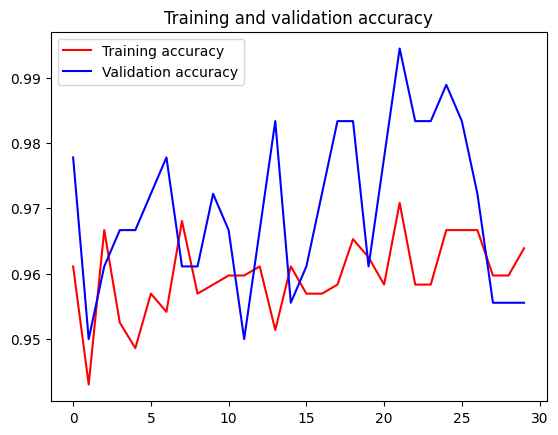

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# New section

In [16]:
model.save('/content/drive/MyDrive/Fruit Decay Detection/model1.h5')

In [17]:
model.save('/content/drive/MyDrive/Fruit Decay Detection/model1.tflite')